In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [44]:
data=pd.read_csv("Resources/Merged_dataset.csv")

### Preprocessing and Feature Engineering

In [45]:
customer_features = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',            # Total revenue
    'TransactionID': 'count',      # Total transactions
    'Quantity': 'sum',             # Total quantity purchased
    'Region': 'first',             # Customer's region
    'SignupDate': 'first'          # Customer signup date
}).reset_index()

In [46]:
customer_features['SignupDate'] = pd.to_datetime(customer_features['SignupDate'])

In [47]:

customer_features['AvgTransactionValue'] = customer_features['TotalValue'] / customer_features['TransactionID']
customer_features['DaysSinceSignup'] = (pd.Timestamp.now() - customer_features['SignupDate']).dt.days


customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

customer_features.drop(columns=['SignupDate'], inplace=True)


In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_cols = ['TotalValue', 'TransactionID', 'Quantity', 'AvgTransactionValue', 'DaysSinceSignup']
customer_features[numerical_cols] = scaler.fit_transform(customer_features[numerical_cols])


In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
reduced_features = pca.fit_transform(customer_features[numerical_cols])

### Find Optimal Number of Clusters (Elbow Method)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

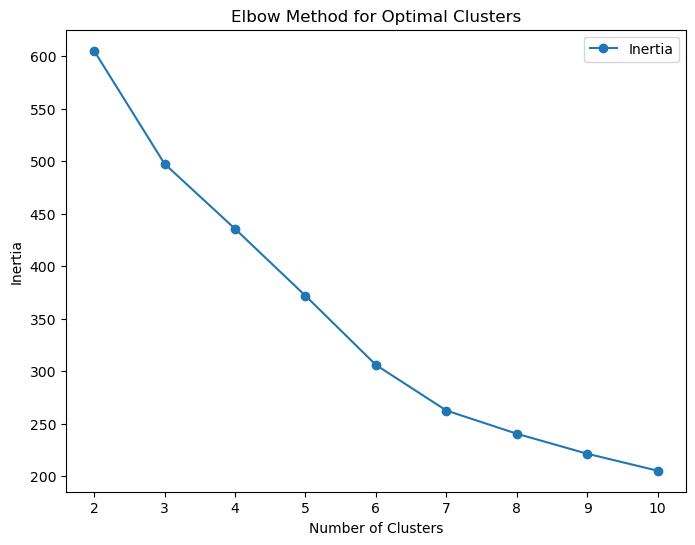

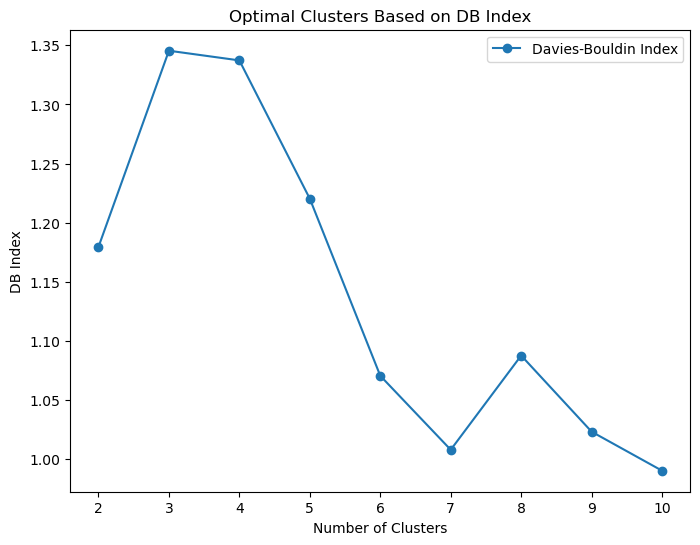

In [50]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score

inertia = []
db_scores = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_features)
    inertia.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(reduced_features, cluster_labels))

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o', label='Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), db_scores, marker='o', label='Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.title('Optimal Clusters Based on DB Index')
plt.legend()
plt.show()


### Selecting the best number of Cluster and Evaluating the score

In [51]:
optimal_clusters = db_scores.index(min(db_scores)) + 2
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(reduced_features)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [52]:
db_index = davies_bouldin_score(reduced_features, customer_features['Cluster'])
sil_score = silhouette_score(reduced_features, customer_features['Cluster'])

print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {sil_score}")

Optimal Number of Clusters: 10
Davies-Bouldin Index: 0.9903120377546222
Silhouette Score: 0.2933311107585517


### Visualizations

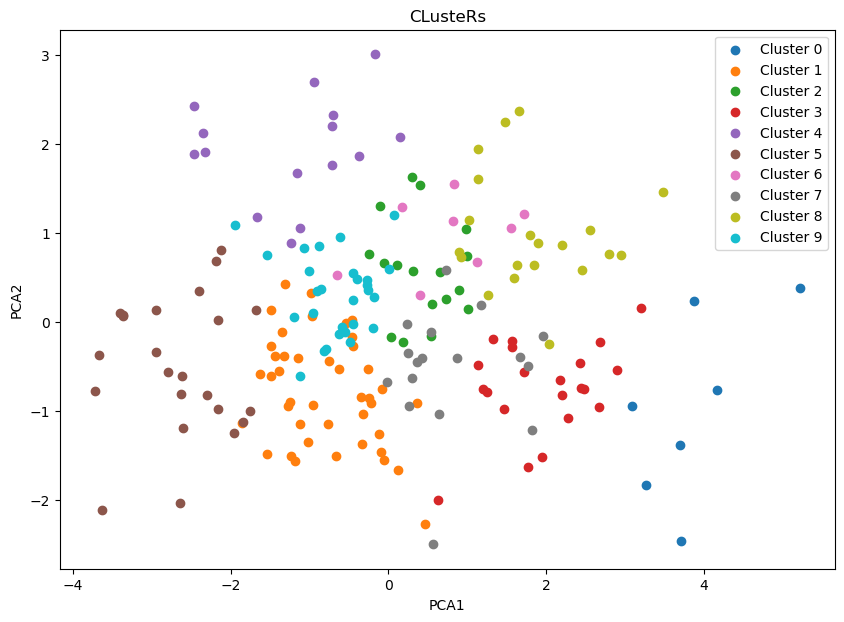

In [54]:
# Visualize clusters in reduced PCA dimensions
plt.figure(figsize=(10, 7))
for cluster_id in range(optimal_clusters):
    cluster_data = reduced_features[customer_features['Cluster'] == cluster_id]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {cluster_id}")

plt.title("CLusteRs")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()
